In [19]:
import pandas as pd
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt
from scipy.signal import correlate
import numpy as np
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [36]:
def tsplot(y, title, lags=None, figsize=(12, 6)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    plt.text(1,-1.4, "Fig. 4.3", size=12, ha="center",weight='bold');
    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=12, fontweight='bold')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    sns.despine()
    plt.tight_layout()
    plt.show()
    return ts_ax, acf_ax, pacf_ax

In [6]:
dataset = pd.read_csv('../Scenario3/data_merged_final.csv',index_col=0)

In [7]:
dataset.head()

,Beer,Car,Steel,Gas,Electricity,Temp
Date,,,,,,
1956-01-01,93.2,12700.116925,196.9,1709,1254,25.1
1956-02-01,96.0,12574.354195,192.1,1646,1290,25.3
1956-03-01,95.2,13050.102235,201.8,1794,1379,24.9
1956-04-01,77.1,11604.703762,186.9,1878,1346,23.9
1956-05-01,70.9,13700.668520,218.0,2173,1535,19.4


In [8]:
CsI=dataset['Beer']
WLS=dataset['Steel']

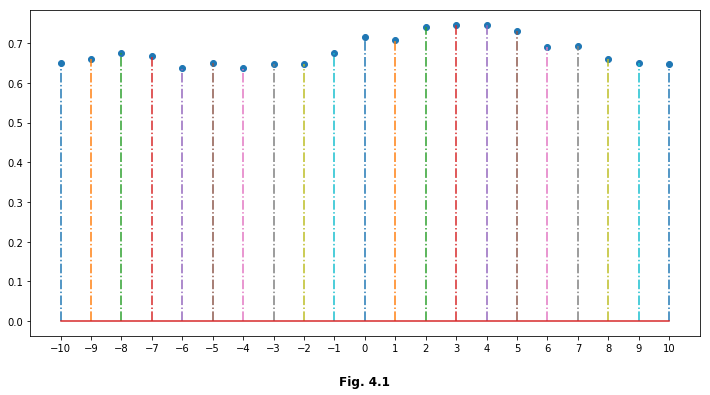

In [38]:
import scipy.signal as ss
import numpy as np
import matplotlib.pyplot as plt

maxlags = 10
result = result = ss.correlate(CsI - np.mean(CsI), WLS - np.mean(WLS), method='direct')/(np.std(CsI)*np.std(WLS)*len(CsI))
lo = (len(result)-1)//2-10 #just get +/- 10 elements around lag 0
hi = (len(result)-1)//2+11

locs = np.arange(lo, hi)
# for loc in locs:
#     print(str(loc)+'\t:\t'+str(result[loc]))

#Make a plot like ccf
f, ax = plt.subplots(figsize=(12,6))
ax.stem(np.arange(-10,11), result[lo:hi], '-.')
ax.set_xticks(np.arange(-10,11))
ax.text(0.5,-0.15, "Fig. 4.1", size=12, ha="center", transform=ax.transAxes,weight='bold')

plt.show()

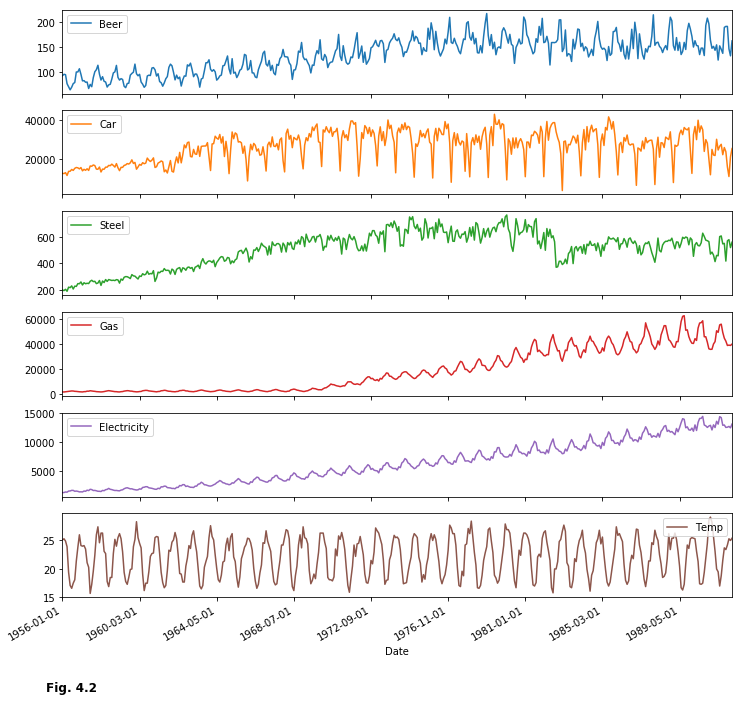

In [29]:
dataset.plot(subplots=True,figsize=(12,12))
plt.text(6,-1.4, "Fig. 4.2", size=12, ha="center",weight='bold');

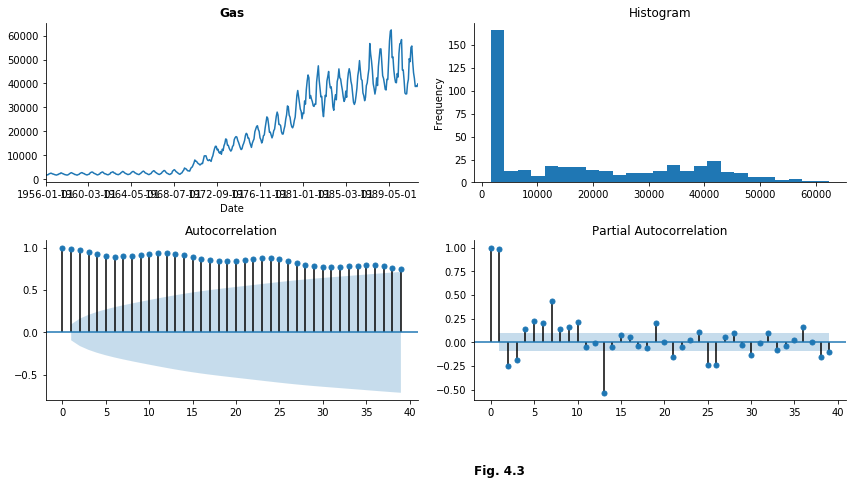

(<matplotlib.axes._subplots.AxesSubplot at 0x1dffa719128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1dff9e589e8>)

In [37]:
tsplot(dataset['Gas'],'Gas',lags=np.arange(0,40))

In [39]:
adf_test(dataset['Temp'])

Results of Dickey-Fuller Test:
Test Statistic                -6.333879e+00
p-value                        2.862096e-08
#Lags Used                     1.800000e+01
Number of Observations Used    4.160000e+02
Critical Value (1%)           -3.446168e+00
Critical Value (5%)           -2.868513e+00
Critical Value (10%)          -2.570484e+00
dtype: float64


For temperature, the test statistic < critical value, which implies that the series is stationary.

In [40]:
adf_test(dataset['Car'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.737860
p-value                          0.067713
#Lags Used                      13.000000
Number of Observations Used    421.000000
Critical Value (1%)             -3.445979
Critical Value (5%)             -2.868430
Critical Value (10%)            -2.570440
dtype: float64


For car, the test statistic < critical value in 10% significance level, which implies that the series is stationary. The cas has growth in the beginning but tends to stationay later.

In [41]:
adf_test(dataset['Steel'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.252618
p-value                          0.187705
#Lags Used                      12.000000
Number of Observations Used    422.000000
Critical Value (1%)             -3.445941
Critical Value (5%)             -2.868413
Critical Value (10%)            -2.570431
dtype: float64


In [42]:
adf_test(dataset['Gas'])

Results of Dickey-Fuller Test:
Test Statistic                   0.205778
p-value                          0.972584
#Lags Used                      17.000000
Number of Observations Used    417.000000
Critical Value (1%)             -3.446129
Critical Value (5%)             -2.868496
Critical Value (10%)            -2.570475
dtype: float64


In [43]:
adf_test(dataset['Electricity'])

Results of Dickey-Fuller Test:
Test Statistic                   1.563761
p-value                          0.997745
#Lags Used                      17.000000
Number of Observations Used    417.000000
Critical Value (1%)             -3.446129
Critical Value (5%)             -2.868496
Critical Value (10%)            -2.570475
dtype: float64


For the above three, transformation to stationary is needed.

In [44]:
dataset['Steel_log'] = np.log(dataset['Steel'])
dataset['Steel_log_diff'] = dataset['Steel_log'] - dataset['Steel_log'].shift(1)
adfuller(dataset['Steel_log_diff'].dropna())

(-6.287739626234377,
 3.662730800933948e-08,
 13,
 420,
 {'1%': -3.4460159927788574,
  '10%': -2.570448781179138,
  '5%': -2.868446209372638},
 -897.0581197796027)

Use log transform for steel.

In [45]:
dataset['Gas_diff_seas'] = dataset['Gas'] - dataset['Gas'].shift(12)
dataset['Gas_diff'] = dataset['Gas_diff_seas'] - dataset['Gas_diff_seas'].shift(1)

In [46]:
adfuller(dataset['Gas_diff'].dropna())

(-7.423805825441933,
 6.629388763872179e-11,
 18,
 403,
 {'1%': -3.4466811208382437,
  '10%': -2.5706046655665635,
  '5%': -2.8687386420385494},
 6970.282319837302)

For gas, first seasonal difference. then difference by 1.

In [47]:
dataset['Electricity_diff_seas'] = dataset['Electricity'] - dataset['Electricity'].shift(12)
dataset['Electricity_diff'] = dataset['Electricity_diff_seas'] - dataset['Electricity_diff_seas'].shift(1)

In [48]:
adfuller(dataset['Electricity_diff'].dropna())

(-6.32664313158624,
 2.9751670322101644e-08,
 17,
 404,
 {'1%': -3.44664043608676,
  '10%': -2.5705951311145965,
  '5%': -2.868720756230461},
 5275.094116151984)

In [49]:
dataset_stationary=dataset.drop(['Steel','Gas','Electricity',\
                                 'Steel_log','Gas_diff_seas','Electricity_diff_seas'],axis=1).iloc[13:]

In [50]:
dataset_stationary.head()

,Beer,Car,Temp,Steel_log_diff,Gas_diff,Electricity_diff
Date,,,,,,
1957-02-01,82.8,13985.911224,24.0,-0.092787,0.0,-58.0
1957-03-01,83.3,14767.651312,24.1,0.069590,84.0,67.0
1957-04-01,80.0,14270.452770,23.5,-0.030697,-63.0,-8.0
1957-05-01,80.4,15046.366905,21.1,0.014658,75.0,2.0
1957-06-01,67.5,14187.495032,20.3,-0.008525,-180.0,-97.0


In [51]:
values = dataset_stationary.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [451]:
# specify the number of lag hours
n_days = 24
n_features = 6

# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, n_days)

reframed.to_csv('input_LSTM.csv')

In [428]:
# split into train and test sets
values = reframed.values
n_train_days = 330
train = values[:n_train_days, :]
test = values[n_train_days:, :]

In [429]:
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:,n_obs::n_features]
test_X, test_y = test[:, :n_obs], test[:,n_obs::n_features]
print(train_X.shape, len(train_X), train_y.shape)

(330, 144) 330 (330, 24)


In [430]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(330, 24, 6) (330, 24) (45, 24, 6) (45, 24)


In [473]:
train_X_all, train_y_all = values[:, :n_obs], values[:,n_obs::n_features]
train_X_all = train_X_all.reshape((train_X_all.shape[0], n_days, n_features))

In [476]:
train_X_all.shape,train_y_all.shape

((375, 24, 6), (375, 24))

In [477]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_days))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X_all, train_y_all, epochs=200, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 375 samples, validate on 45 samples
Epoch 1/200
 - 1s - loss: 0.2063 - val_loss: 0.1217
Epoch 2/200
 - 0s - loss: 0.1881 - val_loss: 0.1194
Epoch 3/200
 - 0s - loss: 0.1904 - val_loss: 0.1199
Epoch 4/200
 - 0s - loss: 0.1815 - val_loss: 0.1178
Epoch 5/200
 - 0s - loss: 0.1710 - val_loss: 0.1160
Epoch 6/200
 - 0s - loss: 0.1624 - val_loss: 0.1159
Epoch 7/200
 - 0s - loss: 0.1547 - val_loss: 0.1150
Epoch 8/200
 - 0s - loss: 0.1457 - val_loss: 0.1145
Epoch 9/200
 - 0s - loss: 0.1368 - val_loss: 0.1129
Epoch 10/200
 - 0s - loss: 0.1256 - val_loss: 0.1078
Epoch 11/200
 - 0s - loss: 0.1072 - val_loss: 0.0992
Epoch 12/200
 - 0s - loss: 0.0930 - val_loss: 0.0921
Epoch 13/200
 - 0s - loss: 0.1019 - val_loss: 0.0898
Epoch 14/200
 - 0s - loss: 0.0808 - val_loss: 0.0882
Epoch 15/200
 - 0s - loss: 0.0887 - val_loss: 0.0859
Epoch 16/200
 - 0s - loss: 0.0778 - val_loss: 0.0869
Epoch 17/200
 - 0s - loss: 0.0768 - val_loss: 0.0864
Epoch 18/200
 - 0s - loss: 0.0747 - val_loss: 0.0869
Epoch 19/2

Epoch 154/200
 - 0s - loss: 0.0585 - val_loss: 0.0616
Epoch 155/200
 - 1s - loss: 0.0576 - val_loss: 0.0616
Epoch 156/200
 - 0s - loss: 0.0562 - val_loss: 0.0621
Epoch 157/200
 - 0s - loss: 0.0598 - val_loss: 0.0616
Epoch 158/200
 - 0s - loss: 0.0587 - val_loss: 0.0615
Epoch 159/200
 - 1s - loss: 0.0606 - val_loss: 0.0614
Epoch 160/200
 - 1s - loss: 0.0574 - val_loss: 0.0611
Epoch 161/200
 - 1s - loss: 0.0555 - val_loss: 0.0615
Epoch 162/200
 - 1s - loss: 0.0578 - val_loss: 0.0610
Epoch 163/200
 - 0s - loss: 0.0585 - val_loss: 0.0611
Epoch 164/200
 - 0s - loss: 0.0581 - val_loss: 0.0608
Epoch 165/200
 - 0s - loss: 0.0568 - val_loss: 0.0607
Epoch 166/200
 - 0s - loss: 0.0557 - val_loss: 0.0611
Epoch 167/200
 - 0s - loss: 0.0587 - val_loss: 0.0607
Epoch 168/200
 - 0s - loss: 0.0580 - val_loss: 0.0610
Epoch 169/200
 - 0s - loss: 0.0581 - val_loss: 0.0605
Epoch 170/200
 - 0s - loss: 0.0554 - val_loss: 0.0603
Epoch 171/200
 - 0s - loss: 0.0563 - val_loss: 0.0604
Epoch 172/200
 - 0s - loss: 

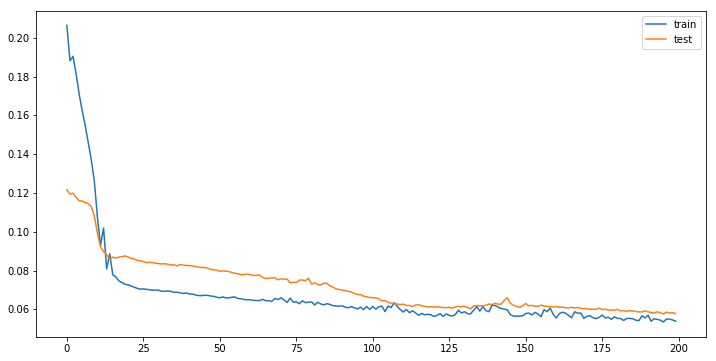

In [478]:
# plot history
fig=plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.text(6,-1.4, "Fig. 4.3", size=12, ha="center",weight='bold');
plt.legend()

In [479]:
test_y[-1:]

array([[0.57351963, 0.56819694, 0.45242848, 0.53892216, 0.53825682,
        0.43978709, 0.84231537, 0.93878909, 0.86360612, 0.64471058,
        0.53626081, 0.56220892, 0.50964737, 0.582169  , 0.37924152,
        0.56886228, 0.52228876, 0.46906188, 0.81503659, 0.82834331,
        0.82834331, 0.52894212, 0.43579508, 0.63539587]])

In [480]:
test_X.shape,yhat.shape,test_X_res.shape,test_y.shape

((45, 24, 6), (1, 24), (45, 144), (45, 24))

In [481]:
yhat=model.predict(test_X[-1:])
test_X_res = test_X.reshape((test_X.shape[0], n_days*n_features))

# invert scaling for forecast

yhat_last24=[]
ytrue_last24=[]

for i in np.arange(n_days):
    inv_yhat = concatenate((yhat[-1:,[i]], test_X_res[-1:, -5:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    yhat_last24.append(inv_yhat)

for i in np.arange(n_days):
    inv_y = concatenate((test_y[-1:,[i]], test_X_res[-1:, -5:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    ytrue_last24.append(inv_y)

In [482]:
yhat=model.predict(np.reshape(test[-1,n_obs:],newshape=(1,n_days,n_features)))
test_X_res = test_X.reshape((test_X.shape[0], n_days*n_features))

# invert scaling for forecast

yhat_future=[]

for i in np.arange(n_days):
    inv_yhat = concatenate((yhat[-1:,[i]], test_X_res[-1:, -5:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    yhat_future.append(inv_yhat)

In [483]:
yhat_future

[array([152.51552664]),
 array([138.85869391]),
 array([134.16951433]),
 array([144.89787746]),
 array([148.69925299]),
 array([151.05538591]),
 array([163.66366187]),
 array([196.96757017]),
 array([185.83429722]),
 array([156.73270562]),
 array([149.34777342]),
 array([161.02483206]),
 array([146.99964051]),
 array([142.90194209]),
 array([133.63986527]),
 array([148.69771212]),
 array([151.19717333]),
 array([146.61835447]),
 array([175.58979585]),
 array([198.8434158]),
 array([192.79560513]),
 array([155.76620046]),
 array([150.37765156]),
 array([162.13171813])]

In [485]:
np.savetxt('../Result in CSV/Li_Scenario4.csv', yhat_future, delimiter=',')

### Prediction Interval

In [52]:
import csv
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [53]:
Beer=pd.read_csv('../Scenario3/data_merged_final.csv',sep=',',index_col=0,usecols=[0,1])

In [55]:
mod = sm.tsa.statespace.SARIMAX(Beer,
                                order=(1, 0, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False,)

results = mod.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:                   Beer   No. Observations:                  435
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1872.418
Date:                Mon, 22 Apr 2019   AIC                           3750.837
Time:                        22:36:31   BIC                           3763.049
Sample:                    01-01-1956   HQIC                          3755.658
                         - 03-01-1992                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9968      0.004    237.065      0.000       0.989       1.005
ma.L1         -0.3107      0.044     -7.066      0.000      -0.397      -0.225
sigma2       335.4263     21.510     15.594      0.0

C:\Users\Jackie Li\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Jackie Li\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


In [57]:
# Get forecast 24 steps ahead in future
pred_uc = results.get_forecast(steps=24)

# Get 95% confidence intervals of forecasts
pred_ci = pred_uc.conf_int(alpha=0.05)

C:\Users\Jackie Li\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [58]:
s=pd.DataFrame(pred_uc.predicted_mean)
s.columns=['Beer']
s.set_index(s.columns[0])
s.index.name='Date'
s.index=s.index.to_period('D')

In [59]:
Beer.index = pd.to_datetime(Beer.index)
Beer.index=Beer.index.to_period('D')

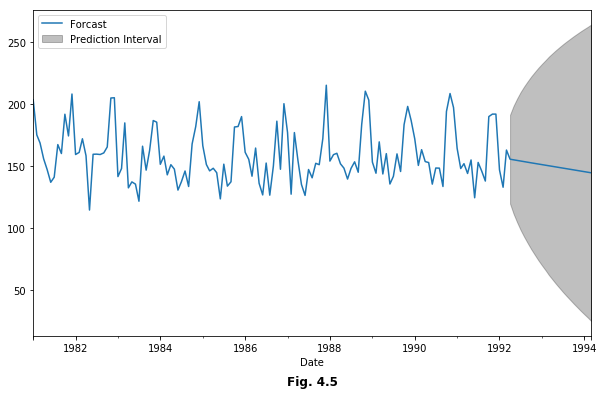

In [64]:
fig, ax = plt.subplots(figsize=(10,6))
Beer.append(s)[300:].plot(ax=ax)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.text(0.5,-0.15, "Fig. 4.5", size=12, ha="center", transform=ax.transAxes,weight='bold')
plt.legend(['Forcast','Prediction Interval'],loc=2)
plt.show()